In [1]:
## Cell 1
## Import modules
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris import *
from iris.analysis import *
from iris.analysis.cartography import *
from iris.coord_categorisation import *
import matplotlib.pyplot as plt
from scipy.stats import *
import sys
import numpy
import iris.coord_categorisation
from numpy import *
from matplotlib.pyplot import *
from scipy.stats.mstats import *
from scipy.optimize import curve_fit
from scipy.optimize import leastsq

In [2]:
## Cell 2
## Read in DHW data

## Read in cube
dhw_cube = iris.load_cube('/data/local_ssd/cj362/S2P3Rv2.0/dhw/dhw_script_outputs/GFDL-CM4_ssp245_daily_dhw.nc')
dhw_cube_name = "GFDL-CM4 ssp2(4.5)"

In [3]:
## Cell 3
## Remove year and month scalar coordinates
## Eventhough we are going to add back in these coordinates later on,
## For some reason if we do not remove them in the first place it causes later variables to become recognised
## as NoneType objects rather than Iris Cubes.
## THIS CELL MUST BE RUN

dhw_cube.remove_coord('year')
dhw_cube.remove_coord('month')
dhw_cube.remove_coord('month_number')

In [4]:
## Cell 4
## Detrending

## Define function to calculate line from which to detrend
def quadratic_function(x,a,b,c):    
    y = (a*(x**2.0)) + (b*x) + c
    return y

## Re-load in dhw cube data to be detrended
dhw_cube_detrended = dhw_cube.copy()                    # Copy cube 
dhw_cube_detrended_data = dhw_cube_detrended.data       # Extract data


## Detrending processing
shape = np.shape(dhw_cube_detrended_data)              # Returns the shape of the array
output_cube_data = dhw_cube_detrended_data.copy()      # Seperate cube to process the data
output_cube_data[:] = np.nan                                         # Converts all values (:) in array to Nan

for i in range(shape[1]):                                  
    for j in range(shape[2]):
        if dhw_cube_detrended_data.mask[0,i,j] == False:
            parameters, var = curve_fit(quadratic_function,np.arange(shape[0]),dhw_cube_detrended_data[:,i,j])
            y_values_anomaly_from_curve = quadratic_function(np.arange(shape[0]), *parameters)
            output_cube_data[:,i,j] = dhw_cube_detrended_data[:,i,j]-y_values_anomaly_from_curve
         
        
# This bit of code essentially deals with all the odd values:
# np.isnan is used to identify where the data value is a Nan value
# the .fill_value function fills the specified data point by default as None
output_cube_data.data[np.where(np.isnan(output_cube_data))] = output_cube_data.fill_value
output_cube_data[np.where(output_cube_data == 0.0)] = output_cube_data.fill_value
output_cube_data.mask[np.where(np.isnan(output_cube_data))] = True    # Masks data values that are Nans to True (meaning they are ignored)
output_cube_data.mask[np.where(output_cube_data == output_cube_data.fill_value)] = True   # Masks data values that have been assigned using fill_value to True also

#Put detrended data back in to the original cube
dhw_cube_detrended.data = output_cube_data #By specifying .data it automatically also affects the overarching dhw_cube_2_annual_max_detrended variable. 

In [5]:
## Cell 5
## Extract for ENSO event interested in

## Define extract_year_range_inclusive_2_years function for ENSO events that span across 2 years
def extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month):
    
    try:  # Add year scalar coordinate
        iris.coord_categorisation.add_year(enso_dhw_cube,'time', name='year')
    except:
        pass
    try:  # Add month scalar coordinate
        iris.coord_categorisation.add_month(enso_dhw_cube,'time', name='month')
    except:
        pass
    try:  # Add month_number scalar coordinate
        iris.coord_categorisation.add_month_number(enso_dhw_cube,'time', name = 'month_number')
    except:
        pass
    
    # Constrain first part of ENSO event
    enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
    enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month <= tmp_mn <= year_1_end_month)
    enso_event_year_1_cube = enso_dhw_cube.extract(enso_event_year_1_year & enso_event_year_1_months)
    #print(type(enso_event_year_1_cube))
    
    # Constrain second part of ENSO event
    enso_event_year_2_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == end_year)
    enso_event_year_2_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month <= tmp_mn <= year_2_end_month)
    enso_event_year_2_cube = enso_dhw_cube.extract(enso_event_year_2_year & enso_event_year_2_months)
    #print(type(enso_event_year_1_cube))
    
    # Merge two cubes together
    enso_event_cube_list = iris.cube.CubeList([enso_event_year_1_cube, enso_event_year_2_cube])
    enso_event_cube = enso_event_cube_list.concatenate()[0]    
    #print(type(enso_event_year_1_cube))
          
    return enso_event_cube




## Define extract_year_range_inclusive_3_years function for ENSO events that span across 3 years
def extract_year_range_inclusive_3_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month,middle_year,year_between_start_month,year_between_end_month):
    
    ## Only use this function if the ENSO event being investigated stretches across three years e.g. 2021,2022,2023
    
    try:  # Add year scalar coordinate
        iris.coord_categorisation.add_year(enso_dhw_cube,'time', name='year')
    except:
        pass
    try:  # Add month scalar coordinate
        iris.coord_categorisation.add_month(enso_dhw_cube,'time', name='month')
    except:
        pass
    try:  # Add month_number scalar coordinate
        iris.coord_categorisation.add_month_number(enso_dhw_cube,'time', name = 'month_number')
    except:
        pass
    
    # Constrain first part of ENSO event
    enso_event_year_1_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == start_year)
    enso_event_year_1_months = iris.Constraint(month_number=lambda tmp_mn: year_1_start_month <= tmp_mn <= year_1_end_month)
    enso_event_year_1_cube = enso_dhw_cube.extract(enso_event_year_1_year & enso_event_year_1_months)

    # Constrain second part of ENSO event
    enso_event_year_2_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == end_year)
    enso_event_year_2_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month <= tmp_mn <= year_2_end_month)
    enso_event_year_2_cube = enso_dhw_cube.extract(enso_event_year_2_year & enso_event_year_2_months)
    
    # Constrain middle part of ENSO event
    enso_event_year_between_year = iris.Constraint(year=lambda tmp_yr: tmp_yr == middle_year)
    enso_event_year_between_months = iris.Constraint(month_number=lambda tmp_mn: year_2_start_month <= tmp_mn <= year_2_end_month)
    enso_event_year_between_cube = enso_dhw_cube.extract(enso_event_year_between_year & enso_event_year_between_months)
    
    # Merge three cubes together
    enso_event_cube_list = iris.cube.CubeList([enso_event_year_1_cube, enso_event_year_2_cube, enso_event_year_between_cube])
    enso_event_cube = enso_event_cube_list.concatenate()[0]    
   
    return enso_event_cube



## Define new cube for ENSO event figure creation
enso_dhw_cube = dhw_cube
enso_event_name = ""



## Define start and end month for specific ENSO event
start_year= 2020
end_year = 2021
# between_year = 2045
year_1_start_month,year_1_end_month = 11, 12
year_2_start_month,year_2_end_month = 1, 5
# year_between_start_month,year_between_end_month = 1, 12



# ENSO events that span two years (use first function):
enso_event_cube = extract_year_range_inclusive_2_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month)

# ENSO events that span three years (use second function):
# enso_event_cube = extract_year_range_inclusive_3_years(enso_dhw_cube,start_year,year_1_start_month,year_1_end_month,end_year,year_2_start_month,year_2_end_month,between_year,year_between_start_month,year_between_end_month)



unknown / (1)                       (time: 211)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          month                          x
          month_number                   x
          year                           x
     Scalar coordinates:
          latitude: -17.0 degrees, bound=(-25.05, -8.95) degrees
          longitude: 148.5 degrees, bound=(141.95, 155.05) degrees
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          mean: longitude, latitude


/home/cj362/anaconda3/envs/python27/lib/python2.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


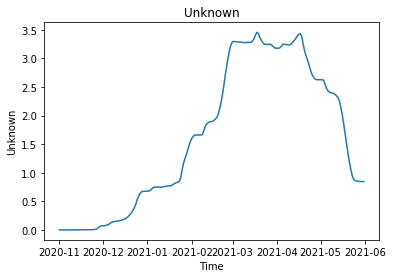

In [6]:
## Cell 6
## Plot timeseries of area mean daily dhw values

## Define function to calculate area mean
def area_mean(enso_event_area_mean):
    try:
        enso_event_area_mean.coord('latitude').guess_bounds()
    except:
        pass
    try:
        enso_event_area_mean.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(enso_event_area_mean)
    return enso_event_area_mean.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

## Re-load iris cube containing area mean
enso_event_area_mean = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_event_area_mean_data = enso_event_area_mean.data
if np.nanmax(enso_event_area_mean_data) > 1000:
    enso_event_area_mean_data[np.where(enso_event_area_mean_data > 1000)] = enso_event_area_mean_data.fill_value
    enso_event_area_mean_data.mask[np.where(enso_event_area_mean_data > 1000)] = True
if np.nanmax(enso_event_area_mean_data) < -1000:
    enso_event_area_mean_data[np.where(enso_event_area_mean_data < -1000)] = enso_event_area_mean_data.fill_value
    enso_event_area_mean_data.mask[np.where(enso_event_area_mean_data < -1000)] = True
    
## Call function to calculate area mean
enso_event_area_mean = area_mean(enso_event_area_mean)   # Call function to average over all grid squares
print(enso_event_area_mean)

qplt.plot(enso_event_area_mean)

unknown / (1)                       (latitude: 161; longitude: 131)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          month: Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|No...
          month_number: 6, bound=(1, 12)
          time: 2021-02-14 12:00:00, bound=(2020-11-01 00:00:00, 2021-05-31 00:00:00)
          year: 2020, bound=(2020, 2021)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          sum: time


/home/cj362/anaconda3/envs/python27/lib/python2.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))
/home/cj362/anaconda3/envs/python27/lib/python2.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'month_number'.
  warnings.warn(msg.format(self.name()))
/home/cj362/anaconda3/envs/python27/lib/python2.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


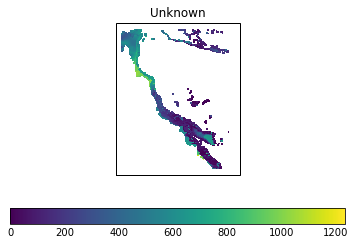

In [7]:
## Cell 7
## Calculate cumulative DHW for each grid square

## Re-load in iris cube containing dhw data
enso_events_total_dhw = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_events_total_dhw_data = enso_events_total_dhw.data
if np.nanmax(enso_events_total_dhw_data) > 1000:
    enso_events_total_dhw_data[np.where(enso_events_total_dhw_data > 1000)] = enso_events_total_dhw_data.fill_value
    enso_events_total_dhw_data.mask[np.where(enso_events_total_dhw_data > 1000)] = True
if np.nanmax(enso_events_total_dhw_data) < -1000:
    enso_events_total_dhw_data[np.where(enso_events_total_dhw_data < -1000)] = enso_events_total_dhw_data.fill_value
    enso_events_total_dhw_data.mask[np.where(enso_events_total_dhw_data < -1000)] = True

## Calculate value sum 
enso_events_total_dhw = enso_events_total_dhw.collapsed('time', iris.analysis.SUM)
print(enso_events_total_dhw)


qplt.pcolormesh(enso_events_total_dhw)

unknown / (1)                       (latitude: 161; longitude: 131)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          month: Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|No...
          month_number: 6, bound=(1, 12)
          time: 2021-02-14 12:00:00, bound=(2020-11-01 00:00:00, 2021-05-31 00:00:00)
          year: 2020, bound=(2020, 2021)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          maximum: time


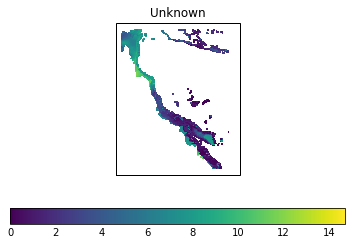

In [8]:
## Cell 8
## Calculate maximum DHW for each grid square

## Re-load in iris cube containing dhw data
enso_events_max_dhw = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_events_max_dhw_data = enso_events_max_dhw.data
if np.nanmax(enso_events_max_dhw_data) > 1000:
    enso_events_max_dhw_data[np.where(enso_events_max_dhw_data > 1000)] = enso_events_max_dhw_data.fill_value
    enso_events_max_dhw_data.mask[np.where(enso_events_max_dhw_data > 1000)] = True
if np.nanmax(enso_events_max_dhw_data) < -1000:
    enso_events_max_dhw_data[np.where(enso_events_max_dhw_data < -1000)] = enso_events_max_dhw_data.fill_value
    enso_events_max_dhw_data.mask[np.where(enso_events_max_dhw_data < -1000)] = True

## Calculate value sum 
enso_events_max_dhw = enso_events_max_dhw.collapsed('time', iris.analysis.MAX)
print(enso_events_max_dhw)

qplt.pcolormesh(enso_events_max_dhw)

unknown / (1)                       (latitude: 161; longitude: 131)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          month: Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|Nov|No...
          month_number: 6, bound=(1, 12)
          time: 2021-02-14 12:00:00, bound=(2020-11-01 00:00:00, 2021-05-31 00:00:00)
          year: 2020, bound=(2020, 2021)
     Attributes:
          CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7
          history: Thu May 27 15:42:01 2021: cdo mergetime GFDL-CM4_ssp245_1970_2100_surfacetemperature_1970.nc...
     Cell methods:
          count: time


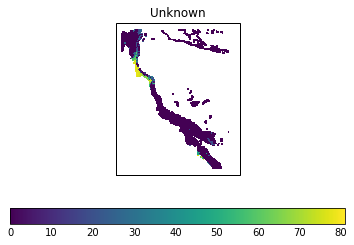

In [9]:
## Cell 9
## DHW bleaching thresholds plot 
## Plotting the number of times that each grid square reaches or exceeds 8 Degree Heating Weeks threshold

## Re-load in data
enso_events_eight_dhw = enso_event_cube

## Filtering out crazy values and assigning them as a Nan
enso_events_eight_dhw_data = enso_events_eight_dhw.data
if np.nanmax(enso_events_eight_dhw_data) > 1000:
    enso_events_eight_dhw_data[np.where(enso_events_eight_dhw_data > 1000)] = enso_events_eight_dhw_data.fill_value
    enso_events_eight_dhw_data.mask[np.where(enso_events_eight_dhw_data > 1000)] = True
if np.nanmax(enso_events_eight_dhw_data) < -1000:
    enso_events_eight_dhw_data[np.where(enso_events_eight_dhw_data < -1000)] = enso_events_eight_dhw_data.fill_value
    enso_events_eight_dhw_data.mask[np.where(enso_events_eight_dhw_data < -1000)] = True

enso_events_eight_dhw = enso_events_eight_dhw.collapsed('time', iris.analysis.COUNT,
                               function=lambda values: values >= 8)

print(enso_events_eight_dhw)
qplt.pcolormesh(enso_events_eight_dhw)

## Filter out crazy values
## (function) Analyse each grid square for each day (two for loops?) then an if statement that catches no. times >=8
# Each instance, add a point to a new cube for each grid square for each day
# Calculate the sum of these points at each grid square using. analysis.SUM

In [19]:
## Cell 10
## Bar chart of DHW threshold occurences
# Trying to plot a bar chart of the number of times that different DHW thresholds were crossed...
# ...totalled from across all grid squares.

# Define function to count the occurences of different DHW thresholds being crossed
def threshold_count (enso_events_dhw_thresholds_data):
    
    # Create for loop to examine all data
    for i in range(0, len(enso_events_dhw_thresholds_data) + 1):
        
        ## PROBLEM IN LINE ABOVE:have tried solutions relating to .any() and .all(), as well as .compressed()
        
        # Define different threshold counts
        enso_event_dhw_1_count = 0
        enso_event_dhw_2_count = 0
        enso_event_dhw_4_count = 0
        enso_event_dhw_8_count = 0
    
        # Define if statements to segment different threshold counts
        if (1 <= enso_events_dhw_thresholds_data[i] < 2):
            enso_event_dhw_1_count = enso_event_dhw_1_count + 1
    
        if (2 <= enso_events_dhw_thresholds_data[i] < 4):
            enso_event_dhw_2_count = enso_event_dhw_2_count + 1
        
        if (8 <= enso_events_dhw_thresholds_data[i] < 8):
            enso_event_dhw_4_count = enso_event_dhw_4_count + 1
        
        if (8 <= enso_events_dhw_thresholds_data[i]):
            enso_event_dhw_8_count = enso_event_dhw_8_count + 1
    
    return enso_event_dhw_1_count, enso_event_dhw_2_count, enso_event_dhw_4_count, enso_event_dhw_8_count


## Re-load in DHW data
enso_events_dhw_thresholds = enso_event_cube
enso_events_dhw_thresholds_data = enso_events_dhw_thresholds.data
print(enso_events_dhw_thresholds_data)
print(type(enso_events_dhw_thresholds_data))

## Call upon function to examine data
threshold_count(enso_events_dhw_thresholds_data)

print(enso_event_dhw_1_count)
print(enso_event_dhw_2_count)
print(enso_event_dhw_4_count)
print(enso_event_dhw_8_count)


[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- 0.0 0.0 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- 0.0 0.0 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- 0.0 0.0 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 ...

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- 0.8695338368415833 0.9279845356941223 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- 0.8695338368415833 0.9279845356941223 ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [-- 0.869533836841

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()